# **EDA Insurance Prediction Premium - First Submission with autogluon**

Lets take advantage of autogluon ecosystem for this first submission. 

In [1]:
%%capture
%pip install -q autogluon autogluon.eda ray==2.2.0 pandas

In [2]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import cloudpickle
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"
pio.templates.default = "simple_white"
warnings.filterwarnings('ignore')

# Import specific libraries
import autogluon.eda.auto as auto
from autogluon.tabular import TabularDataset, TabularPredictor

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
submission = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
original = pd.read_csv("/kaggle/input/insurance-premium-prediction/Insurance Premium Prediction Dataset.csv")

Lets prepare the datasets

In [4]:
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

# Renaming columns for consistency
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()
original.columns = original.columns.str.lower()
train.columns = [col.replace(" ", "_") for col in train.columns]
test.columns = [col.replace(" ", "_") for col in test.columns]
original.columns = [col.replace(" ", "_") for col in original.columns]
original  = original[train.columns]
original = original.dropna(subset=['premium_amount'])

train

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,previous_claims,vehicle_age,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount
id,,,,,,,,,,,,,,,,,,,,
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,36.0,Female,27316.0,Married,0.0,Master's,Unemployed,13.772907,Urban,Premium,NaN,5.0,372.0,3.0,2023-05-03 15:21:39.257696,Poor,No,Daily,Apartment,1303.0
1199996,54.0,Male,35786.0,Divorced,NaN,Master's,Self-Employed,11.483482,Rural,Comprehensive,NaN,10.0,597.0,4.0,2022-09-10 15:21:39.134960,Poor,No,Weekly,Apartment,821.0
1199997,19.0,Male,51884.0,Divorced,0.0,Master's,NaN,14.724469,Suburban,Basic,0.0,19.0,NaN,6.0,2021-05-25 15:21:39.106582,Good,No,Monthly,Condo,371.0


# **Autogluon EDA**

I've recently found autogluon has also a EDA component. Lets try it out.

## **Dataset Overview**

**`train_data` dataset summary (sample size: 0.2)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,special_types
age,236095,47,,,41.133887,13.549034,18.0,29.0,41.0,53.0,64.0,float64,3905,0.016271,float,
annual_income,231029,53028,,,32760.817599,32257.176026,1.0,7988.0,23892.0,44619.0,149997.0,float64,8971,0.037379,float,
credit_score,212629,550,,,592.798329,149.979089,300.0,468.0,595.0,721.0,849.0,float64,27371,0.114046,float,
customer_feedback,224306,3,Average,75561,,,,,,,,object,15694,0.065392,object,
education_level,240000,4,Master's,60790,,,,,,,,object,,,object,
exercise_frequency,240000,4,Weekly,60847,,,,,,,,object,,,object,
gender,240000,2,Male,120688,,,,,,,,object,,,object,
health_score,225206,155472,,,25.613702,12.193693,2.024415,15.92999,24.583438,34.53491,58.401009,float64,14794,0.061642,float,
insurance_duration,240000,9,,,5.0131,2.591798,1.0,3.0,5.0,7.0,9.0,float64,,,float,
location,240000,3,Rural,80342,,,,,,,,object,,,object,


### Feature Distance

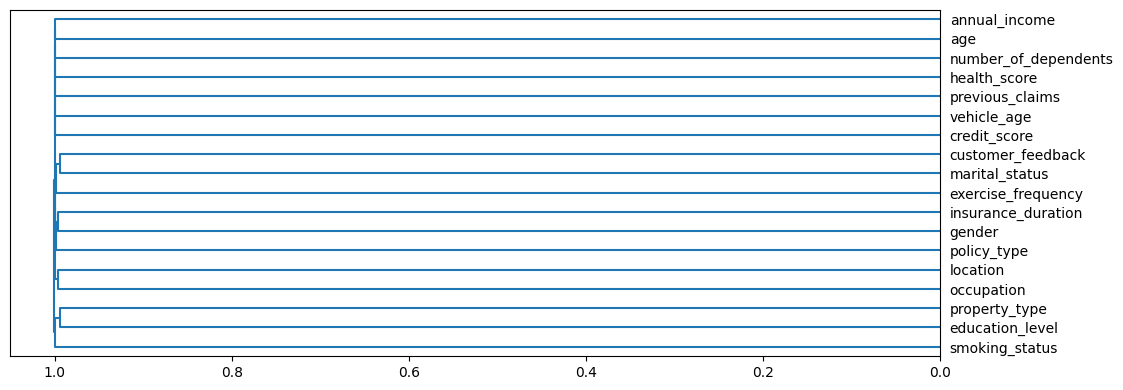

In [5]:
target_col = 'premium_amount'
auto.dataset_overview(train_data=train, label=target_col, sample=0.2)

- There are mostly categorical variables, with one date variable.
- We could do feature engineering with the policy start date, for example, relate the start with the age. Probable there could be some information as you took the policy later in life.
- We do have missing values but it does not seem severe. 

## **Target Analysis**

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
premium_amount,240000,1101.084063,865.250909,20.0,513.0,871.0,1507.0,4997.0,float64,4426,,,float,


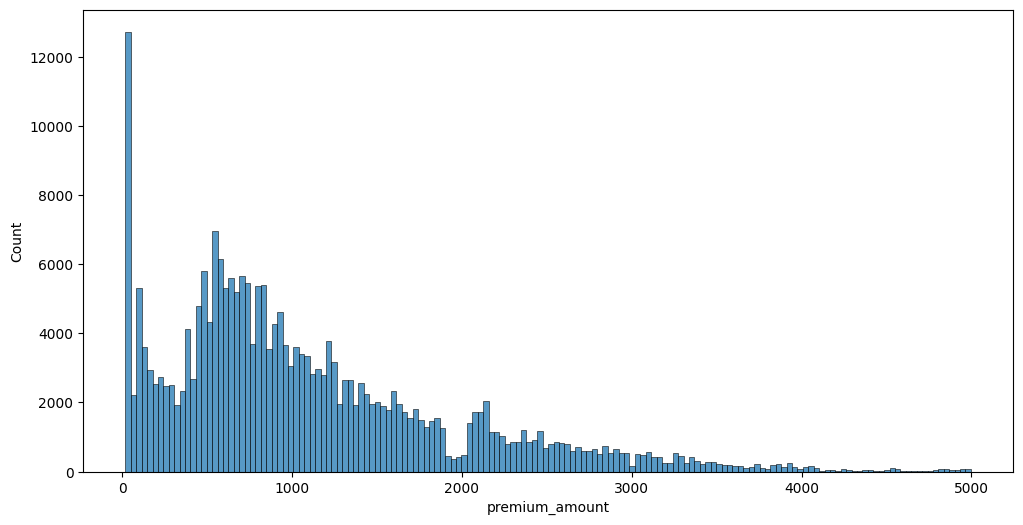

### Target variable correlations
 - ⚠️ no fields with absolute correlation greater than `0.5` found for target variable `premium_amount`.

In [6]:
auto.target_analysis(train_data=train, label=target_col, sample=0.2, problem_type="regression", fit_distributions=False)

- We have a long tail scenario, with a peak very near zero.
- It seems that correlation is low with the target.

Lets transform the target for better analysis.

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
premium_amount,240000,2.861074,0.479349,1.30103,2.710117,2.940018,3.178113,3.698709,float64,4426,,,float,


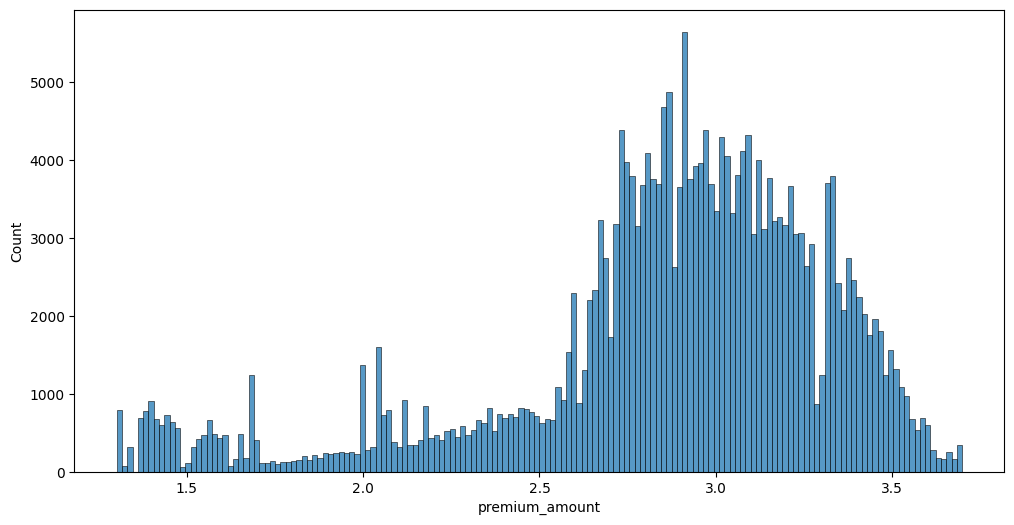

### Target variable correlations
 - ⚠️ no fields with absolute correlation greater than `0.5` found for target variable `premium_amount`.

In [7]:
train_log = train.copy()
train_log['premium_amount'] = np.log10(train_log['premium_amount'])
auto.target_analysis(train_data=train_log, label="premium_amount", sample=0.2, problem_type="regression", fit_distributions=False)

Lets compare with the **original dataset**

## Target variable analysis

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
premium_amount,55404,-inf,,-inf,2.462398,2.839478,3.137671,3.698883,float64,4266,,,float,


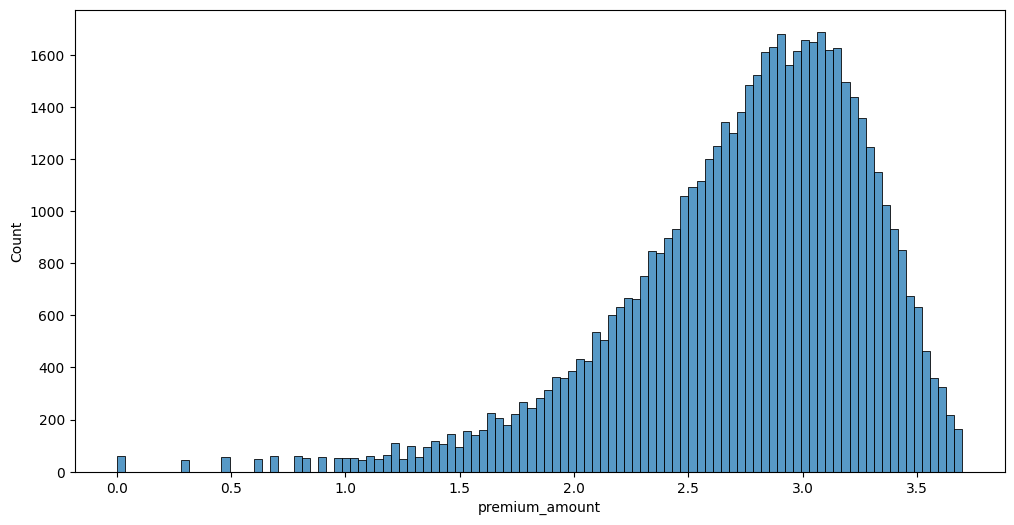

### Target variable correlations
 - ⚠️ no fields with absolute correlation greater than `0.5` found for target variable `premium_amount`.

In [8]:
original_log = original.copy()
original_log['premium_amount'] = np.log10(original_log['premium_amount'])
auto.target_analysis(train_data=original_log, label="premium_amount", sample=0.2, problem_type="regression", fit_distributions=False)

- Overall they have similar distribution, although the training data looks noisy for the target.
- The training data has a bunch of low value observations which could be problematic.
- The original data has a higher mean. 

## **Missing values Analysis**

### Missing Values Analysis

,missing_count,missing_ratio
age,9491,0.015818
annual_income,22484,0.037473
marital_status,9317,0.015528
number_of_dependents,54984,0.091640
occupation,179094,0.298490
health_score,37174,0.061957
previous_claims,182158,0.303597
vehicle_age,4,0.000007
credit_score,68755,0.114592
customer_feedback,38979,0.064965


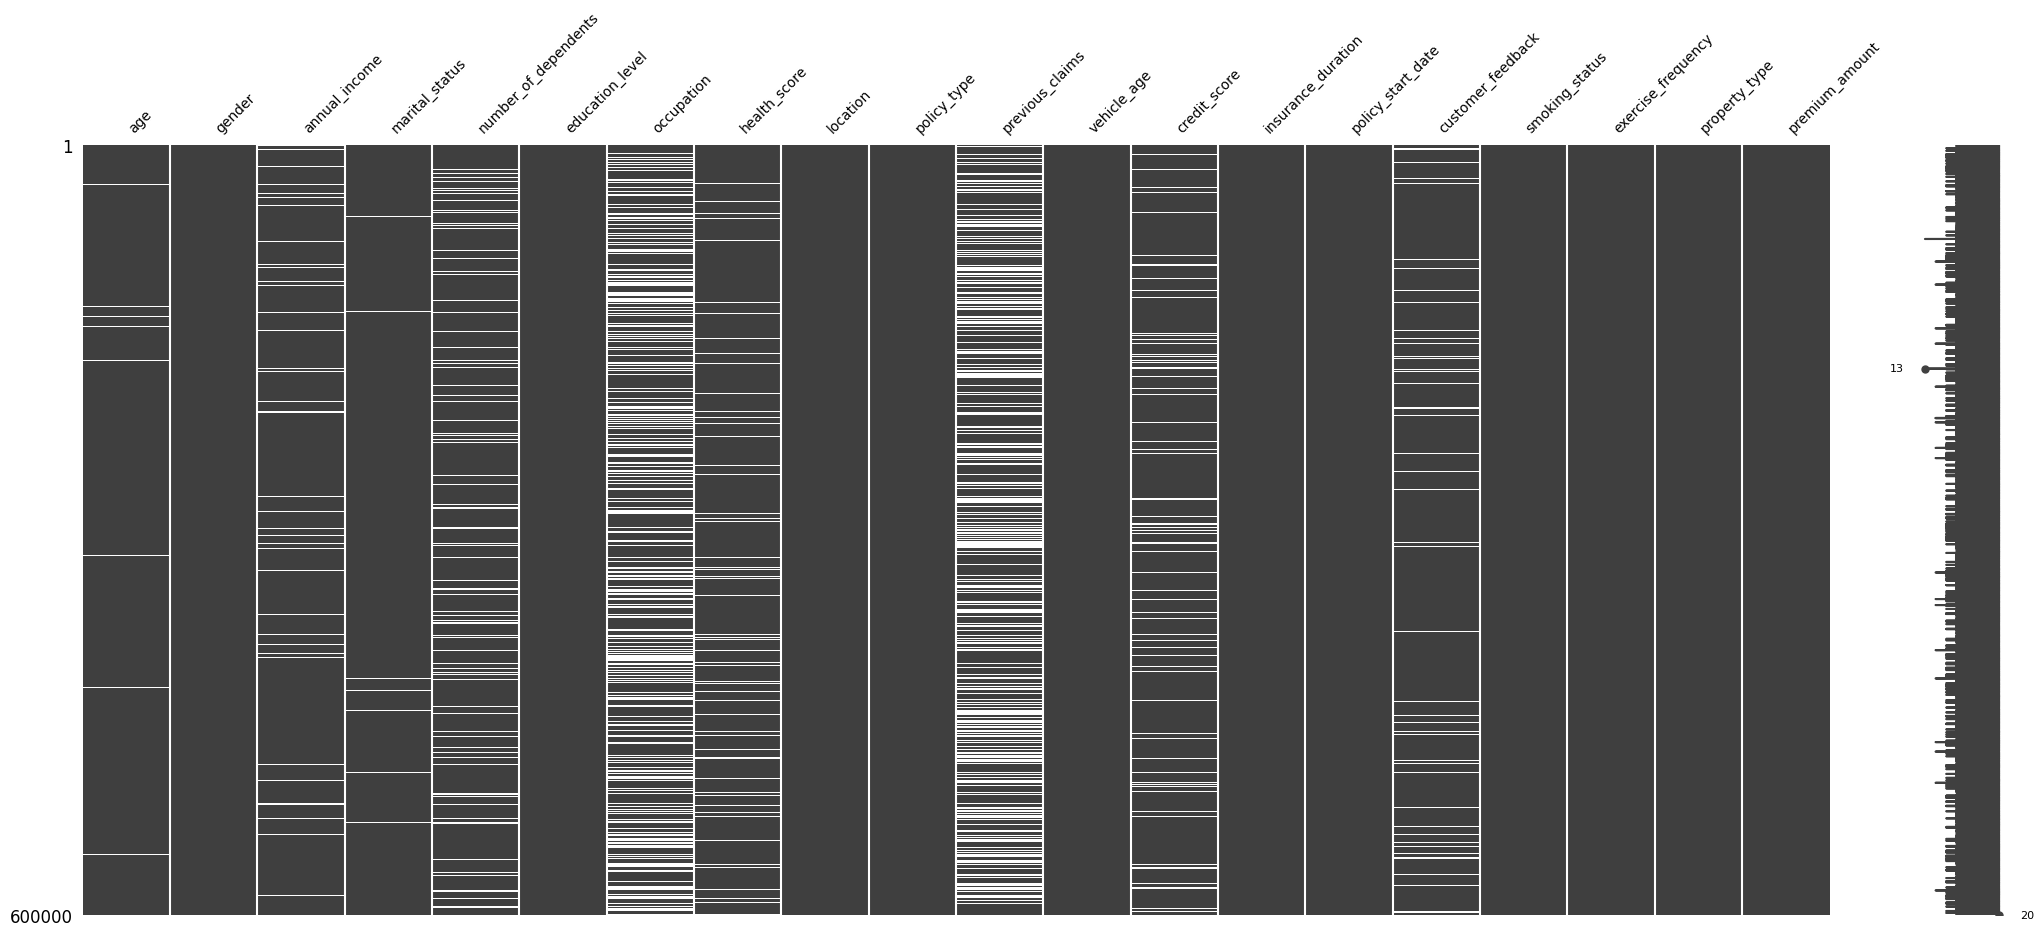

In [9]:
auto.missing_values_analysis(train_data=train, sample=0.5)

- `occupation` and `previous_claims` have the highest missing values.
- It doesn't seem that a there are concentrated rows with missing values. 

## **Covariate shift analysis**

## **Train - Test**

In [10]:
auto.covariate_shift_detection(train_data=train, test_data=test, label=target_col, sample=0.2)

We did not detect a substantial difference between the training and test X distributions.

## **Train - Original**

We detected a substantial difference between the training and test X distributions,
a type of distribution shift.

**Test results**: We can predict whether a sample is in the test vs. training set with a `roc_auc` of
`0.7091` with a p-value of `0.0010` (smaller than the threshold of `0.0100)`.



**Feature importances**: The variables that are the most responsible for this shift are those with high feature importance:



,importance,stddev,p_value,n,p99_high,p99_low
annual_income,0.126287,0.008735,0.000003,5,0.144272,0.108301
credit_score,0.060022,0.006576,0.000017,5,0.073562,0.046482
health_score,0.047703,0.005869,0.000027,5,0.059786,0.035619
previous_claims,0.009795,0.000997,0.000013,5,0.011847,0.007743


**`annual_income` values distribution between datasets; p-value: `0.0000`**

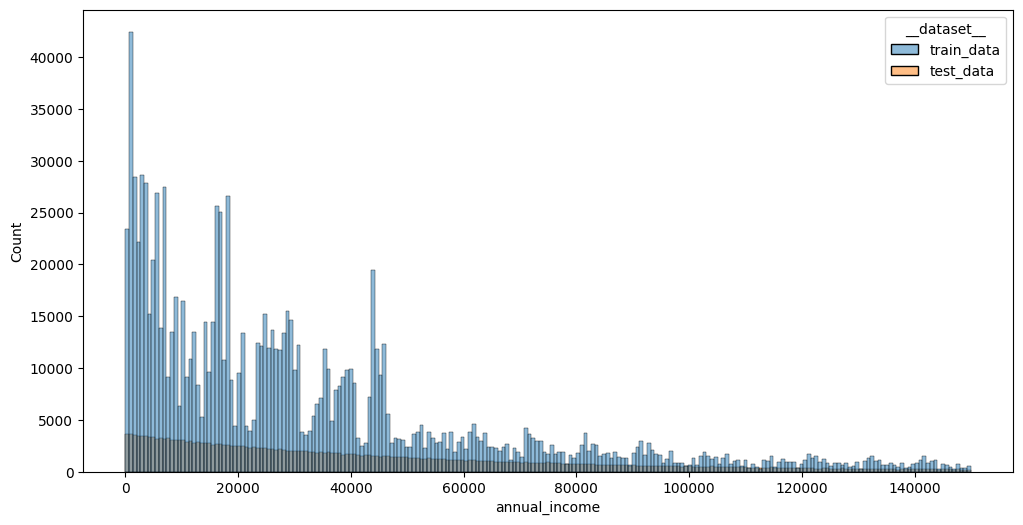

**`credit_score` values distribution between datasets; p-value: `0.0000`**

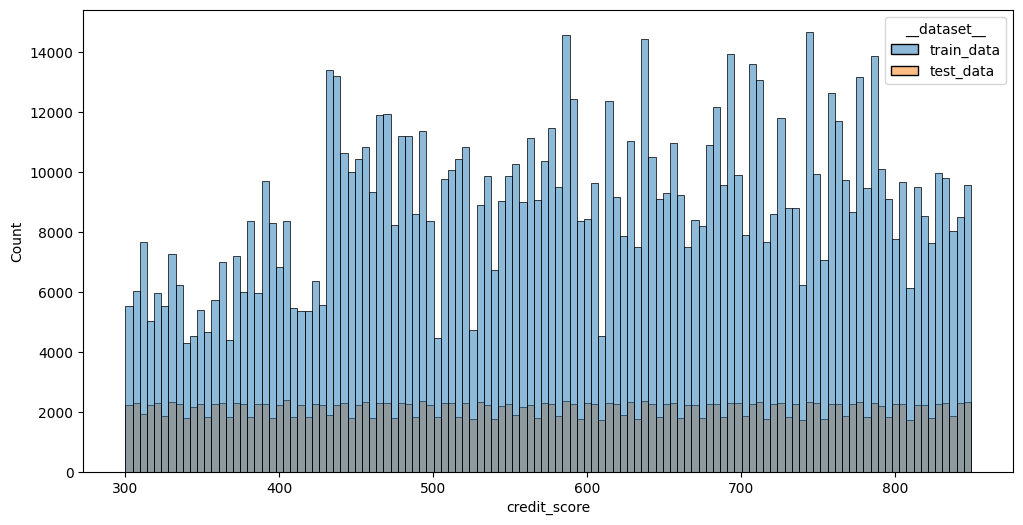

**`health_score` values distribution between datasets; p-value: `0.0000`**

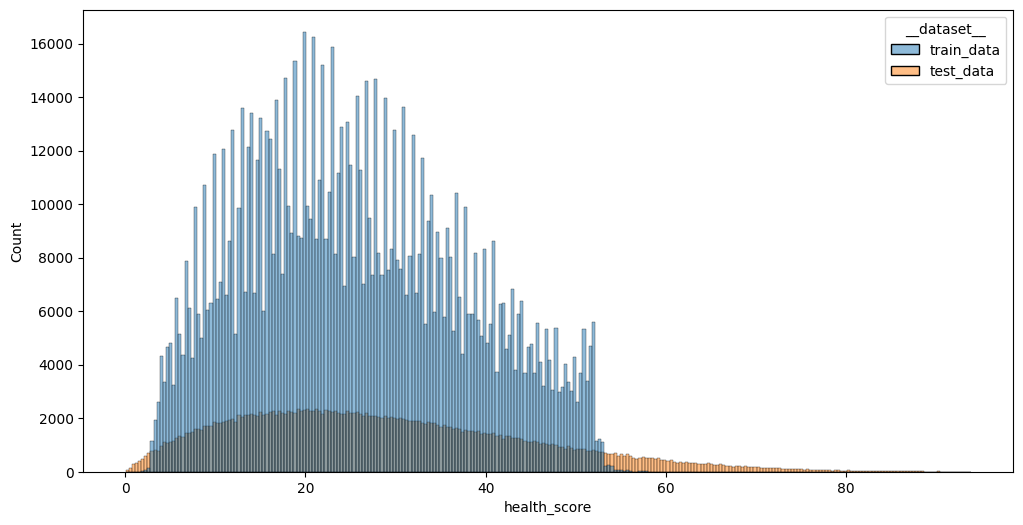

**`previous_claims` values distribution between datasets; p-value: `0.0000`**

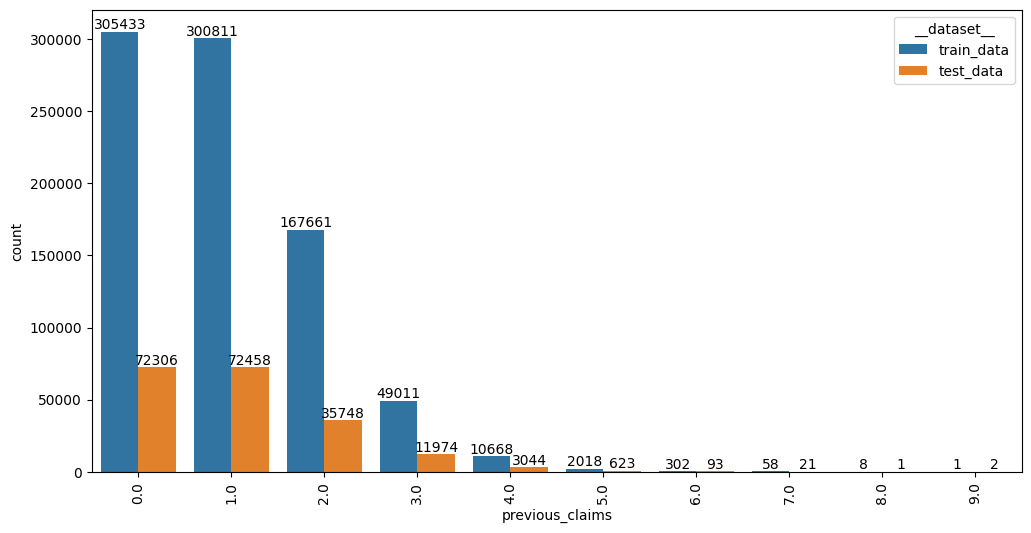

In [11]:
auto.covariate_shift_detection(train_data=train, test_data=original, label=target_col, sample=0.2)

- Interesting, its seems the original dataset is significantly different from train.
- ¿Could this worsen the scores? Maybe, for now we will train with only training set. 

## **Quick Fit**

## **Without Original Dataset**

No path specified. Models will be saved in: "AutogluonModels/ag-20241214_232117/"


### Model Prediction for premium_amount

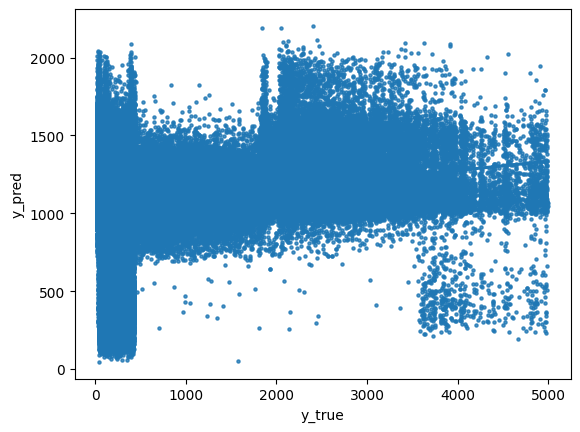

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-837.620019,-834.519341,37.029995,0.869585,87.297559,37.029995,0.869585,87.297559,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
annual_income,60.484996,3.547111,0.000001,5,67.788546,53.181445
credit_score,33.025775,3.949303,0.000024,5,41.157443,24.894106
previous_claims,26.320749,3.855375,0.000054,5,34.259020,18.382479
health_score,13.655363,3.168496,0.000324,5,20.179340,7.131386
customer_feedback,9.564281,2.007564,0.000220,5,13.697884,5.430679
policy_start_date,8.090124,0.871555,0.000016,5,9.884668,6.295581
marital_status,1.986497,0.633327,0.001088,5,3.290525,0.682468
occupation,0.335644,0.508234,0.106900,5,1.382105,-0.710818
policy_type,0.292956,0.119083,0.002662,5,0.538151,0.047762
exercise_frequency,0.245511,0.337634,0.089642,5,0.940705,-0.449682


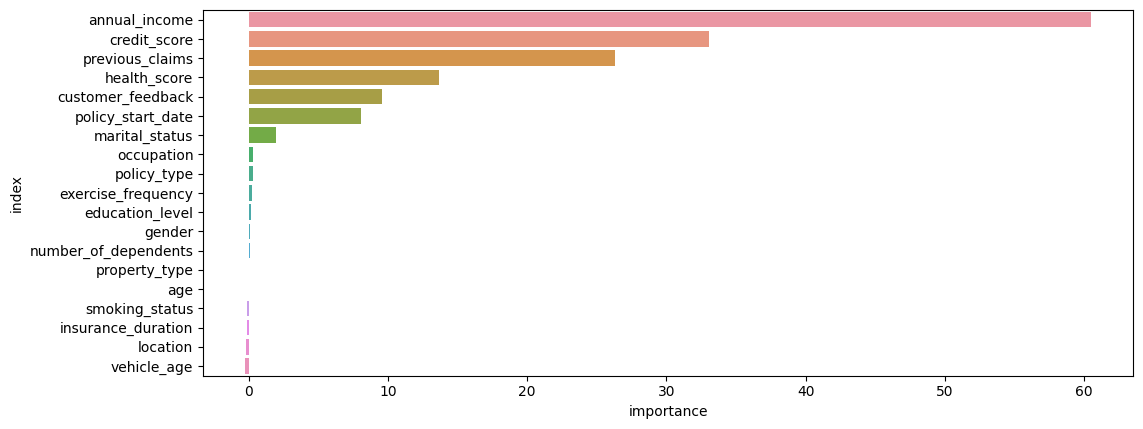

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,...,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount,premium_amount_pred,error
id,,,,,,,,,,,,,,,,,,,,,
1025987,56.0,Female,73488.0,Divorced,0.0,Master's,Employed,27.142705,Suburban,Comprehensive,...,634.0,3.0,2022-01-03 15:21:39.118178,Average,No,Weekly,Condo,4979.0,233.333084,4745.666916
208818,33.0,Female,91339.0,Married,0.0,PhD,Employed,27.734147,Urban,Premium,...,622.0,9.0,2021-06-13 15:21:39.134960,Good,No,Rarely,Apartment,4963.0,241.419861,4721.580139
603739,37.0,Female,96690.0,Married,2.0,Master's,NaN,12.733813,Rural,Basic,...,695.0,3.0,2021-02-02 15:21:39.172097,Average,No,Weekly,House,4956.0,269.336884,4686.663116
167451,35.0,Male,88837.0,Married,0.0,Master's,NaN,14.082959,Rural,Basic,...,796.0,5.0,2021-09-20 15:21:39.237118,Average,No,Weekly,Condo,4975.0,304.475189,4670.524811
241044,43.0,Female,66815.0,Married,3.0,PhD,Employed,31.639156,Suburban,Basic,...,622.0,6.0,2023-04-12 15:21:39.134960,Good,Yes,Daily,House,4961.0,301.708038,4659.291962
1074847,64.0,Male,120749.0,Single,0.0,Bachelor's,NaN,19.519569,Urban,Basic,...,779.0,4.0,2022-12-23 15:21:39.223901,Good,No,Rarely,Condo,4934.0,289.773743,4644.226257
540129,48.0,Female,91333.0,Single,1.0,Bachelor's,Unemployed,29.886444,Rural,Basic,...,759.0,8.0,2020-12-28 15:21:39.251142,Good,No,Daily,House,4970.0,340.868469,4629.131531
1091721,48.0,Female,68991.0,Married,0.0,High School,Unemployed,31.251220,Urban,Premium,...,745.0,4.0,2023-11-07 15:21:39.249100,Good,Yes,Weekly,Condo,4857.0,236.852371,4620.147629
20940,52.0,Male,116467.0,Married,NaN,High School,Unemployed,7.239627,Suburban,Premium,...,823.0,2.0,2022-03-25 15:21:39.132191,Average,Yes,Daily,Condo,4976.0,358.415466,4617.584534


In [12]:
auto.quick_fit(train, target_col, show_feature_importance_barplots=True)

## **With Original Dataset**

No path specified. Models will be saved in: "AutogluonModels/ag-20241214_232534/"


### Model Prediction for premium_amount

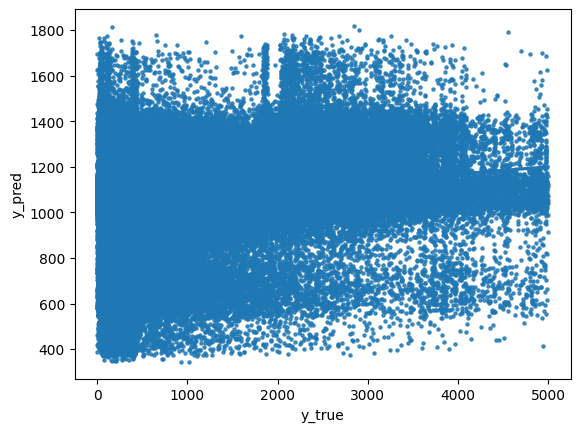

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-859.251676,-859.081372,11.611605,0.286032,39.039135,11.611605,0.286032,39.039135,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
annual_income,27.807606,4.649346,0.000090,5,37.380673,18.234539
credit_score,13.004451,2.850975,0.000260,5,18.874648,7.134254
previous_claims,9.907005,4.077174,0.002784,5,18.301962,1.512048
health_score,7.244266,1.113770,0.000065,5,9.537533,4.950999
customer_feedback,4.201827,0.927228,0.000267,5,6.111003,2.292652
policy_start_date,3.005782,1.238828,0.002798,5,5.556546,0.455019
marital_status,0.367297,0.720090,0.158854,5,1.849972,-1.115377
location,0.075058,0.093300,0.073215,5,0.267164,-0.117048
education_level,0.067635,0.214001,0.259371,5,0.508266,-0.372996
number_of_dependents,0.062259,0.115612,0.147454,5,0.300307,-0.175788


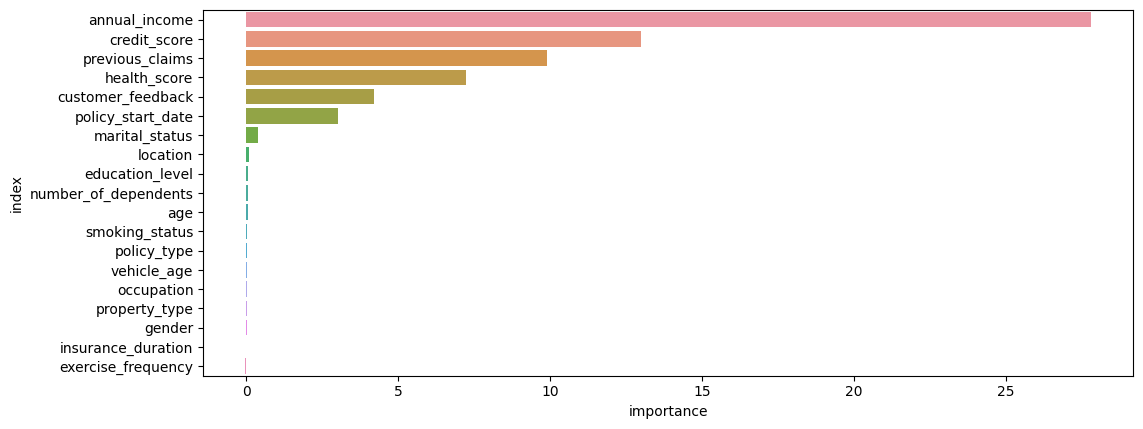

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,age,gender,annual_income,marital_status,number_of_dependents,education_level,occupation,health_score,location,policy_type,...,credit_score,insurance_duration,policy_start_date,customer_feedback,smoking_status,exercise_frequency,property_type,premium_amount,premium_amount_pred,error
1321101,19.0,Female,NaN,Divorced,0.0,Bachelor's,NaN,17.486862,Suburban,Basic,...,713.0,3.0,2023-06-30 15:21:39.171102,Good,Yes,Monthly,House,4939.0,412.451782,4526.548218
167451,35.0,Male,88837.0,Married,0.0,Master's,NaN,14.082959,Rural,Basic,...,796.0,5.0,2021-09-20 15:21:39.237118,Average,No,Weekly,Condo,4975.0,554.340576,4420.659424
1194866,57.0,Male,141161.0,Married,4.0,PhD,Unemployed,16.804418,Urban,Basic,...,709.0,9.0,2023-01-17 15:21:39.173834,Average,Yes,Monthly,Condo,4930.0,537.044800,4392.955200
603739,37.0,Female,96690.0,Married,2.0,Master's,NaN,12.733813,Rural,Basic,...,695.0,3.0,2021-02-02 15:21:39.172097,Average,No,Weekly,House,4956.0,567.286560,4388.713440
208818,33.0,Female,91339.0,Married,0.0,PhD,Employed,27.734147,Urban,Premium,...,622.0,9.0,2021-06-13 15:21:39.134960,Good,No,Rarely,Apartment,4963.0,595.081970,4367.918030
243443,33.0,Male,131346.0,Married,1.0,PhD,NaN,22.734979,Urban,Premium,...,NaN,7.0,2020-05-07 15:21:39.288099,Poor,Yes,Rarely,Apartment,4982.0,615.994446,4366.005554
364163,26.0,Female,114253.0,Divorced,0.0,PhD,NaN,23.955287,Suburban,Basic,...,644.0,1.0,2020-10-03 15:21:39.177724,Good,Yes,Monthly,Condo,4880.0,549.108643,4330.891357
1346155,37.0,Male,NaN,Divorced,0.0,Bachelor's,NaN,2.854361,Urban,Comprehensive,...,515.0,2.0,2023-05-24 15:21:39.190215,Average,Yes,Monthly,Apartment,4989.0,663.414368,4325.585632
60316,53.0,Male,74913.0,Divorced,1.0,Master's,Self-Employed,12.511639,Rural,Basic,...,NaN,4.0,2024-06-18 15:21:39.081504,Average,No,Daily,Apartment,4927.0,602.546021,4324.453979
207155,45.0,Male,73686.0,Married,2.0,PhD,Employed,37.441545,Urban,Basic,...,834.0,3.0,2023-07-01 15:21:39.105504,Poor,No,Rarely,Condo,4959.0,650.333862,4308.666138


In [13]:
original.index = list(range(train.index.max()+1, train.index.max()+1 + len(original)))
train_or = pd.concat([train, original], axis=0)
auto.quick_fit(train_or, target_col, show_feature_importance_barplots=True)

- A quickfit using original data made the score worse. 

# **Autogluon Train 8 hours**

In [14]:
# Lets transform the target and variables
train['premium_amount_log'] = np.log10(train['premium_amount'])

In [15]:
# Setting up
eval_metric = 'rmse'
label = 'premium_amount_log'
problem_type='regression'
hours = 8

# Models to exclude
excluded_model_types = ['KNN']

# Initialize the TabularPredictor
predictor = TabularPredictor(label=label, eval_metric=eval_metric, problem_type=problem_type,
                             path = "/kaggle/working/Autogluon/202412_ps4s12_8hr_training")



# Fit the model
predictor.fit(train_data=train.drop(columns="premium_amount"),
              time_limit=3600*hours,
              presets="best_quality",
              excluded_model_types=excluded_model_types,
              num_bag_folds=20,
              num_bag_sets = 20,
              num_stack_levels=3,
              ag_args_fit={'num_gpus': 1},
              
)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=20, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 28800s
AutoGluon will save models to "/kaggle/working/Autogluon/202412_ps4s12_8hr_training/"
AutoGluon Version:  0.7.0
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
Train Data Rows:    1200000
Train Data Columns: 19
Label Column: premium_amount_log
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    31031.51 MB
	Train Data (Original)  Memory Usage: 922.22 MB (3.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to

In [16]:
leaderboard_test = predictor.leaderboard(silent=True)
leaderboard_test

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.456732,140.189415,4854.788471,0.026345,9.413179,3,True,6
1,WeightedEnsemble_L2,-0.456873,69.990589,2018.744694,0.026096,9.595611,2,True,3
2,ExtraTreesMSE_BAG_L2,-0.456908,101.255167,2633.321316,31.290673,624.172232,2,True,5
3,WeightedEnsemble_L4,-0.456909,211.113550,7779.606255,0.026888,9.528303,4,True,9
4,WeightedEnsemble_L5,-0.457046,284.166913,10667.611431,0.026797,9.393276,5,True,12
5,ExtraTreesMSE_BAG_L3,-0.457098,171.580699,5451.570779,31.417630,606.195487,3,True,8
6,ExtraTreesMSE_BAG_L4,-0.457197,242.774042,8384.887758,31.687380,614.809805,4,True,11
7,RandomForestMSE_BAG_L2,-0.457319,108.872396,4221.203059,38.907902,2212.053976,2,True,4
8,RandomForestMSE_BAG_L1,-0.457381,37.657839,1477.655489,37.657839,1477.655489,1,True,1
9,RandomForestMSE_BAG_L3,-0.457416,179.669033,7163.882465,39.505964,2318.507174,3,True,7


# **Submission**

In [17]:
models = leaderboard_test.head(5)['model'].to_list()
best_model = models[0]
print("Best model by autogluon is", models[0])
print("With a score of RMSLE", np.abs(leaderboard_test[leaderboard_test['model']==best_model]['score_val'][0]))

sub_autogluon = submission.copy()
sub_autogluon['premium_amount_log'] = predictor.predict(test, as_pandas=False, model=best_model)
sub_autogluon['Premium Amount'] = np.power(10, sub_autogluon['premium_amount_log'])
sub_autogluon.drop(columns="premium_amount_log", inplace=True)
sub_autogluon.to_csv(f"/kaggle/working/submission.csv", index=False)

Best model by autogluon is WeightedEnsemble_L3
With a score of RMSLE 0.45673222972268923


In [18]:
oofs = {}
for model in models:
    print("Model:", model)
    oofs_model = predictor.get_oof_pred(model=model)
    oofs[model] = pd.DataFrame(oofs_model.values, index=train.index, columns=[f'{model}_preds'])

with open("/kaggle/working/oofs.pkl", 'wb') as f:
    cloudpickle.dump(oofs, f)

Model: WeightedEnsemble_L3
Model: WeightedEnsemble_L2
Model: ExtraTreesMSE_BAG_L2
Model: WeightedEnsemble_L4
Model: WeightedEnsemble_L5
